In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [3]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        np.random.seed(0)
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        
        # Backward pass
    def backward(self, dvalues):
 
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_Linear:
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()
        

class Activation_Sigmoid:
    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
    
    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

        
class Activation_tanh:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = (np.exp(inputs)-np.exp(-inputs))/(np.exp(inputs)+np.exp(-inputs))
        
    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output**2)
        

class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):

        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Leaky_ReLU:
    # Forward pass
    def forward(self, inputs):

        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0.2 * inputs, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0.2
        

class Activation_Softmax:
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
            
class Loss:
# Calculates the data losses
# given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

        
# Mean Squared Error loss
class Loss_MeanSquaredError(Loss): # L2 loss
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
    
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

In [4]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [7]:
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df['target'] = housing.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [8]:
from sklearn.model_selection import train_test_split

# Collect the data 

X = housing.data
y = housing.target

print('Original Data Shape: ', X.shape, y.shape)

# Split the data in training and testing 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

print('Splited Data Shape: ',X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Original Data Shape:  (20640, 8) (20640,)
Splited Data Shape:  (14448, 8) (14448,) (6192, 8) (6192,)


epoch: 0, loss: 226.844, 
epoch: 100, loss: 131.925, 
epoch: 200, loss: 88.019, 
epoch: 300, loss: 61.095, 
epoch: 400, loss: 43.134, 
epoch: 500, loss: 31.058, 
epoch: 600, loss: 24.373, 
epoch: 700, loss: 20.249, 
epoch: 800, loss: 17.238, 
epoch: 900, loss: 14.863, 
epoch: 1000, loss: 12.925, 
epoch: 1100, loss: 11.315, 
epoch: 1200, loss: 9.962, 
epoch: 1300, loss: 8.817, 
epoch: 1400, loss: 7.843, 
epoch: 1500, loss: 7.011, 
epoch: 1600, loss: 6.299, 
epoch: 1700, loss: 5.687, 
epoch: 1800, loss: 5.162, 
epoch: 1900, loss: 4.709, 
epoch: 2000, loss: 4.320, 
epoch: 2100, loss: 3.984, 
epoch: 2200, loss: 3.693, 
epoch: 2300, loss: 3.443, 
epoch: 2400, loss: 3.226, 
epoch: 2500, loss: 3.038, 
epoch: 2600, loss: 2.876, 
epoch: 2700, loss: 2.736, 
epoch: 2800, loss: 2.614, 
epoch: 2900, loss: 2.508, 
epoch: 3000, loss: 2.416, 
epoch: 3100, loss: 2.337, 
epoch: 3200, loss: 2.267, 
epoch: 3300, loss: 2.207, 
epoch: 3400, loss: 2.154, 
epoch: 3500, loss: 2.109, 
epoch: 3600, loss: 2.069, 

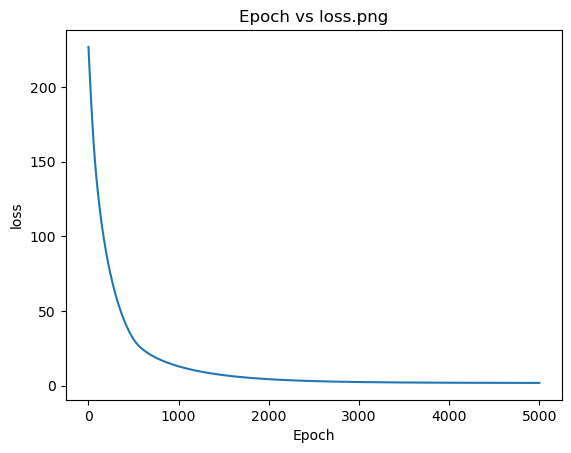

In [19]:
y_train = y_train.reshape(-1, 1)

dense1 = Layer_Dense(8, 32)

activation1 = Activation_ReLU()

dense2 = Layer_Dense(32, 16)

activation2 = Activation_ReLU()

dense3 = Layer_Dense(16, 1)

activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_SGD(learning_rate=0.00000001)


loss_list = list()


# Training Loop
for epoch in range(5001):

    dense1.forward(X_train)

    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    
    activation3.forward(dense3.output)
    
    y_hat = activation3.output
    
    loss = loss_function.calculate(y_hat, y_train)
    
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'loss: {loss:.3f}, ')
    
    loss_list.append(loss)

    # Backward pass
    loss_function.backward(activation3.output, y_train)
    
    activation3.backward(loss_function.dinputs)

    dense3.backward(activation3.dinputs)

    activation2.backward(dense3.dinputs)

    dense2.backward(activation2.dinputs)
    
    activation1.backward(dense2.dinputs)

    dense1.backward(activation1.dinputs)

    
    # Update the Weights and Biases
    
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)

    # Draw the plot
plt.plot(loss_list)
plt.title('Epoch vs loss.png')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [20]:
dense1.forward(X_test)

activation1.forward(dense1.output)

dense2.forward(activation1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

y_hat = activation3.output

#print(y_hat)
loss = loss_function.calculate(y_hat, y_test)

print(loss)

1.773527725906214


In [21]:
check_df = pd.DataFrame(data=np.column_stack([y_test,y_hat]), columns=['Actual','Predicted'])
check_df

,Actual,Predicted
0,0.47700,1.565285
1,0.45800,1.664711
2,5.00001,1.495969
3,2.18600,1.760103
4,2.78000,1.576154
...,...,...
6187,2.37500,2.209702
6188,0.67300,1.326490
6189,2.18400,3.809947
6190,1.19400,4.423410
